# Derived Variables

In this step we will analyze new features, derived from original metrics, to enrich the available information.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from toolkit import Viz, Tools, PF

# Pre configure modules
warnings.filterwarnings('ignore')
sns.set()

In [2]:
# Get data
data, target_col, cat_cols, num_cols = PF.import_data()
X, y = data[cat_cols + num_cols], data[target_col]

# Add zero dense mark and strata
X, zdense_cols, f0_col = PF.full_zero_mark(X)
X, strt_col = PF.add_strata(X, y)
X, num_cols = PF.remove_duplicates(X)
data = pd.concat([X, y], axis=1)
cntr_cols = [f0_col, strt_col]

---
## Time Based Metrics

### Absolute Percentage Change

As we saw before, original data is a set of daily metrics. Additionally, the dataset covers all daily data for a single year for a set of devices.

Because of this it is a common practice to involve time-oriented metrics. 
- One example is the time that has elapsed since last failure (in terms of months / years or business defined cycles). Unfortunately, data for one year is not enough for such metric.

We will work with **absolute daily percentage change** for each metric. This is, how much each metric changed relative to devices' previous daily metric. Note that for this, we must first group **by device** so that the measure is consistent with device’s history.

- The ambition behind this metric is the idea that, device-relative extreme measures, can lead to a failing device.

One additional variable will be included, which is how much **days have passed** (elapsed) since last measure for the same device.

- It is expected that most values for this new feature is 1 day, but maybe, when it is greater than 1, can lead to a failing device as well. **Interruption as a lead to failure**.

In [3]:
# Function for absolute percentage change of metrics and day difference for date (elapsed)
def change_metrics(data):
    # Sort data by device and date
    data_sort = data.sort_values(cat_cols)
    Xsort, ysort = data_sort[cat_cols + num_cols + cntr_cols], data_sort[target_col]

    # Create elapsed column
    elapsed = Xsort[cat_cols].groupby('device').diff().bfill()['date']

    # Create absolute change dataframe
    Xchng = Xsort[['device'] + num_cols].groupby('device').pct_change().fillna(0).abs()
    Xchng.columns = [c.replace('m', 'ch') for c in Xchng.columns]
    Xchng.insert(0, 'device', Xsort['device'])
    Xchng.insert(1, 'date', Xsort['date'])
    Xchng.insert(2, 'elapsed', elapsed.dt.days)
    Xchng.insert(Xchng.shape[1], cntr_cols[0], Xsort[cntr_cols[0]])
    Xchng.insert(Xchng.shape[1], cntr_cols[1], Xsort[cntr_cols[1]])
    
    # Merge new features
    chng_cols = [c for c in Xchng.columns if c not in cat_cols + cntr_cols]
    data_chng = pd.concat([Xchng, ysort], axis=1).sort_index()

    return data_chng, chng_cols

# Get time based metrics
data_chng, chng_cols = change_metrics(data)
Xchng = data_chng[cat_cols + chng_cols + cntr_cols]

#### Infinite Values

- Note that for any metric, if for subsequent days, metric value changes from zero, the change metric will be +/- inf.
- These values will be replaced by 0, since its occurrence is really low.
- Additionally, it is important to analyze a switch-like variable that represents these changes (from / to zero)
- When checking +/- inf proportions, few cases may indicate failure but is not quite representative. This is shown below.

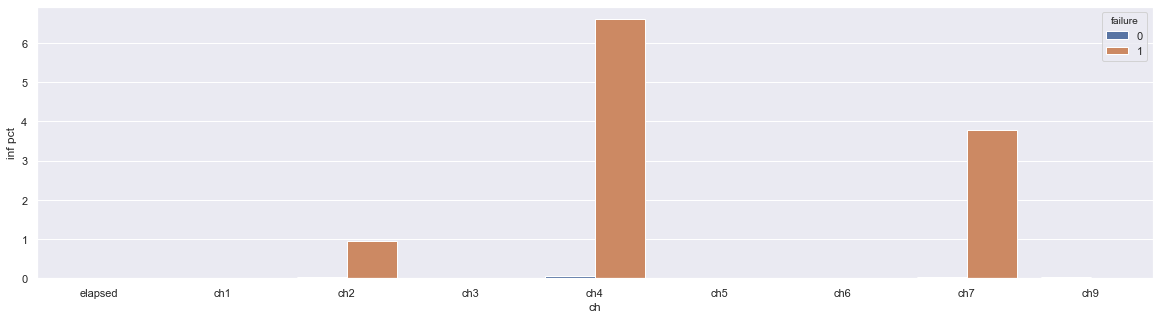

,elapsed,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch9
failure,,,,,,,,,
0,0,0.01,0.04,0.01,0.05,0,0,0.04,0.03
1,0,0.00,0.94,0.00,6.60,0,0,3.77,0.00


In [4]:
# Check for inf value proportion by target
inf_pct = Tools.get_percentage(Xchng[chng_cols], y, values=[np.inf])
minf_pct = inf_pct.reset_index().melt(id_vars=target_col ,value_vars=chng_cols, var_name='ch', value_name='inf pct')
sns.barplot(x='ch', y='inf pct', hue=target_col, data=minf_pct, ax=Viz.get_figure(1))
plt.show()
inf_pct

In [5]:
# Replace inf values
Xchng = Xchng.replace([np.inf], 0)
data_chng = pd.concat([Xchng, y], axis=1)

# Undersample Change Data
Xchng_rs, strt_rs = Tools.stratified_undersample(Xchng, X[strt_col], PF.strata_p)
yrs = y.loc[Xchng_rs.index]
data_rs = pd.concat([Xchng_rs, yrs], axis=1)

#### Zero Values

Note below that zero values represent majority of data (aligned with original metrics data).

- Stratified Under sampling will solve for this issue, as explained before.

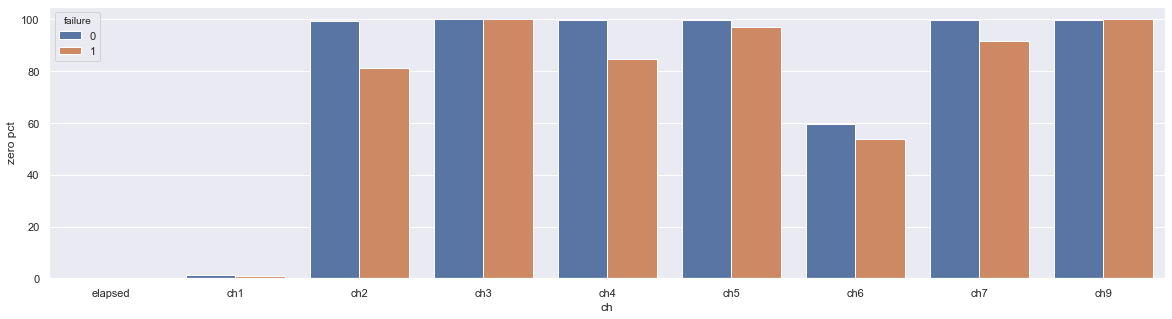

,elapsed,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch9
failure,,,,,,,,,
0,0,1.22,99.32,99.99,99.91,99.64,59.46,99.97,99.96
1,0,0.94,81.13,100.00,84.91,97.17,53.77,91.51,100.00


In [6]:
# Check for zero value proportion by target
zero_pct = Tools.get_percentage(Xchng[chng_cols], y, values=[0])
mzero_pct = zero_pct.reset_index().melt(id_vars=target_col ,value_vars=chng_cols, var_name='ch', value_name='zero pct')
sns.barplot(x='ch', y='zero pct', hue=target_col, data=mzero_pct, ax=Viz.get_figure(1))
plt.show()
zero_pct

#### Change Metrics Distribution

Below you can evaluate how the distributions for the entire dataset is affected when removing zero values on each change metric.

**Note:** Execute one line of code at a time. The first line does not remove 0's, the second one does.

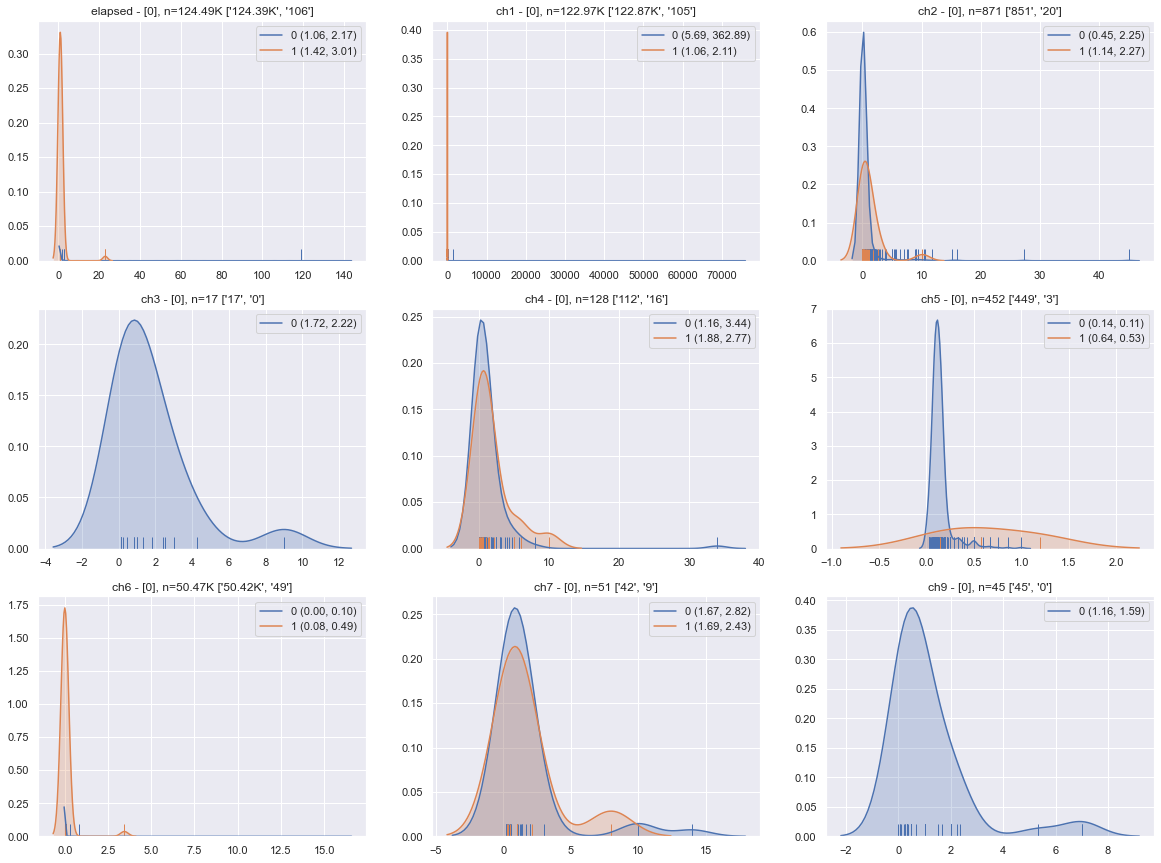

In [9]:
# Create distribution plot per new change metric and target
# Can remove zero values if desired
Viz.change_default(3)
#Viz.kernel_plot(Xchng, y, chng_cols, remove_val=[None], rug_sample=2500)
Viz.kernel_plot(Xchng, y, chng_cols, remove_val=[0], rug_sample=2500)

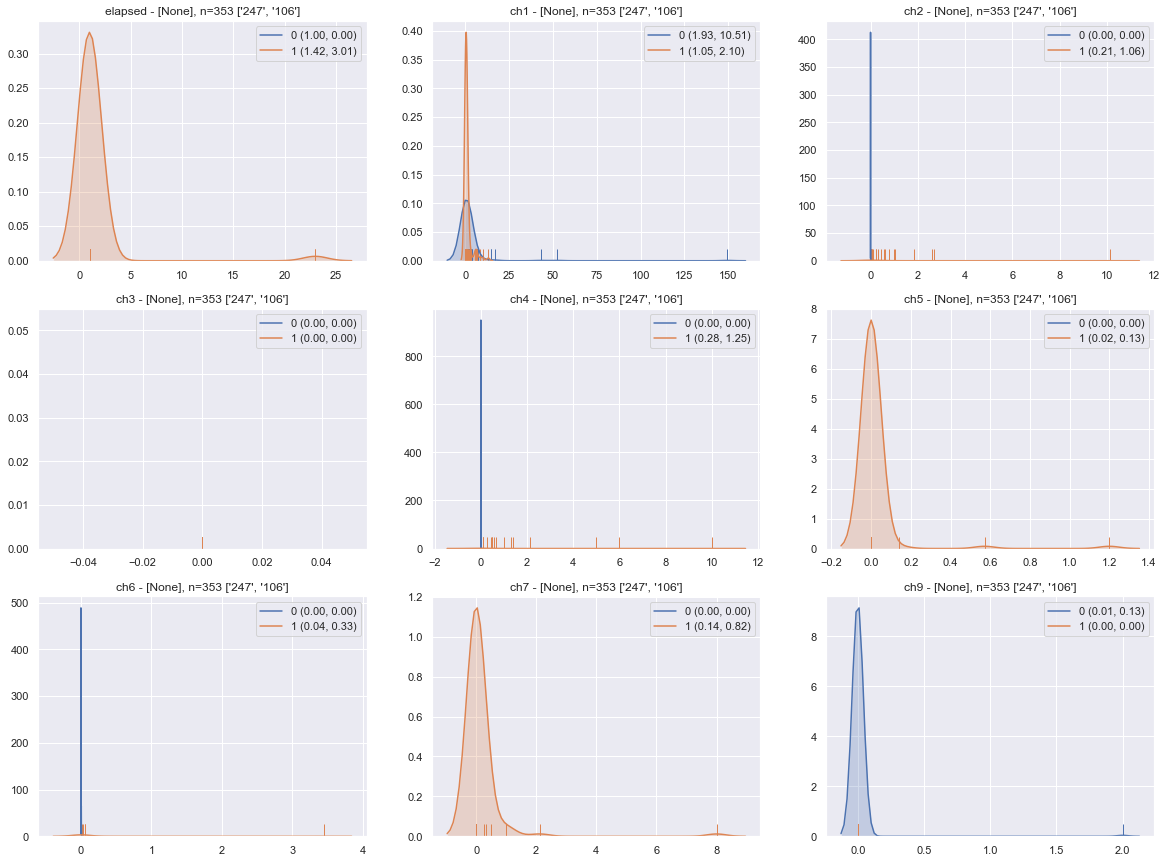

In [10]:
# Create distribution plot per new metric and target for undersample data
Viz.kernel_plot(Xchng_rs, yrs, chng_cols, remove_val=[None], rug_sample=2500)

#### Change Metrics Distribution - Conclusions

- Elapsed (days between subsequent metrics for each device), may not be a good predictor. Failure curve is contained by the ok curve. Perhaps extreme cases are more likely for failure (shifted mean and wider std).
- CH3, CH9, are bad predictors. It seems that all values for failure are 0 or +/- inf, so no relevant info is added.
- CH1 seems to be a good predictor. Failure values are really concentrated, while ok values are widespread and centered apart of failure’s main concentration.
- CH2, CH4, CH6 seem to be good predictors. Ok values will almost always be around 0. Failure curve has a wider spectrum (covering oks curve).
- CH5, CH7 seem to be good predictors as well. Same explanation than CH2, CH4.
- It is important to highlight that once again; 0 values will represent the majority of data for values derived from zero intensive original columns. This means that curves are represented mainly by really few cases.
- Because of this, oversampling can be of good use when building the model.

#### Change Metrics Correlation

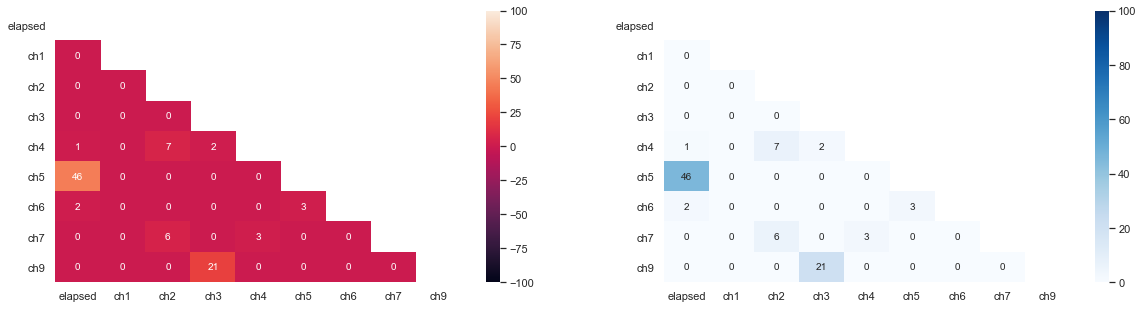

In [13]:
# Check correlation between change metrics
Viz.change_default()
corr_matrix = Tools.get_corr(Xchng, chng_cols)
Viz.corr_plot(corr_matrix)

#### Change Metrics Correlation - Conclusions

- There is not much correlation between change metrics.
- Elapsed and CH5 show a moderate correlation (seems random because of metrics definition).

---
### On / Off Switch

This variable is also time oriented. But the idea behind it is to represent when, for a single device, data turned from or to zero compared to last daily metric.

Is like and on / off switch. Values will be -1, 0 or 1.

Hopefully it compensates for replaced infinite values of change metrics.

In [15]:
# Funtion for on / off switch feature (when metric changes from 0 or to 0 in subsequent measures)
def switch_metrics(data):
    # Sort data 
    data_sort = data.sort_values(cat_cols)
    Xsort, ysort = data_sort[cat_cols + num_cols + cntr_cols], data_sort[target_col]

    # Create switch dataframe
    Xswtch = pd.concat([Xsort[['device']], (Xsort[num_cols] != 0).astype(int)], axis=1)
    Xswtch = Xswtch.groupby('device').diff().fillna(0).astype(int)
    Xswtch.columns = [c.replace('m', 'sw') for c in Xswtch.columns]
    Xswtch.insert(0, 'device', Xsort['device'])
    Xswtch.insert(1, 'date', Xsort['date'])
    Xswtch.insert(Xswtch.shape[1], cntr_cols[0], Xsort[cntr_cols[0]])
    Xswtch.insert(Xswtch.shape[1], cntr_cols[1], Xsort[cntr_cols[1]])
    
    # Merge new features
    swtch_cols = [c for c in Xswtch.columns if c not in cat_cols + cntr_cols]
    data_swtch = pd.concat([Xswtch, ysort], axis=1).sort_index()

    return data_swtch, swtch_cols

data_swtch, swtch_cols = switch_metrics(data)
Xswtch = data_swtch[cat_cols + swtch_cols + cntr_cols]

#### Values Proportion

Bellow you can easily analyze value proportions. This is leveraged by a custom function in `Tools` class of **toolkit.py** file. This function is:

```python
def get_percentage(cls, X, y, values=[0]):
        """ Calculates percentage of specified values in all columns of X, separated by y values."
```

You can change values which proportion you need to analyze. Un document an execute one line at a time as needed.

In [20]:
# Check for 0 or 1 / -1 (together or separatelly) value proportion by target
# Change values as desired
#Tools.get_percentage(Xswtch[swtch_cols], y, values=[0])
Tools.get_percentage(Xswtch[swtch_cols], y, values=[-1, 1])
#Tools.get_percentage(Xswtch[swtch_cols], y, values=[1])
#Tools.get_percentage(Xswtch[swtch_cols], y, values=[-1])

,sw1,sw2,sw3,sw4,sw5,sw6,sw7,sw9
failure,,,,,,,,
0,0.02,0.04,0.01,0.05,0,0,0.05,0.03
1,0.00,0.94,0.00,6.60,0,0,5.66,0.00


#### Values Proportion - Conclusions

- Definitely this is not a good metric to use
- Values are too few to be relevant (for failure and ok target).

---
## Aggregate Metrics

### Average / Maximum Standardized Rank

This metric is aggregate bound. 

The idea is simple, rank each instance by each metric value. 
- Tied values receive the same minimum rank (to keep zeros as low as possible).
- Subtract 1 to each rank so that minimum value is 0 (for 0 metric values).
- Standardize ranks so that all data is in same scale (from 0 to 1). This resulting value will be similar to a percentile, but not quite, since rank for tied values always keep minimum rank.

Additionally, aggregate all standardized ranks for each instance by calculating the mean and the max for each. This will be two additional metrics.

The idea behind this metric, is to highlight as much as possible extreme values, since the main theory so far is that within these extreme values, we can find failing patterns.

**Note:** This will add some complexity for new instances when deployed the model, but it can be handled by storing the state of ranks in a NoSQL in-memory high performant databases for example.

In [21]:
# Function for rank metrics
def rank_metrics(data):
    
    # Create rank dataframe
    Xrnk = data[num_cols].rank(method='min').sub(1).div(data.shape[0])
    Xrnk.columns = [c.replace('m', 'sr') for c in Xrnk.columns]
    Xrnk['srav'] = Xrnk.mean(axis=1)
    Xrnk['srmx'] = Xrnk.max(axis=1)
    Xrnk.insert(0, 'device', data['device'])
    Xrnk.insert(1, 'date', data['date'])
    Xrnk.insert(Xrnk.shape[1], cntr_cols[0], data[cntr_cols[0]])
    Xrnk.insert(Xrnk.shape[1], cntr_cols[1], data[cntr_cols[1]])

    # Merge new features
    rnk_cols = [c for c in Xrnk.columns if c not in cat_cols + cntr_cols]
    data_rnk = pd.concat([Xrnk, y], axis=1).sort_index()

    return data_rnk, rnk_cols

# Get rank metrics
data_rnk, rnk_cols = rank_metrics(data)
Xrnk = data_rnk[cat_cols + rnk_cols + cntr_cols]

# Undersample Rank Data
Xrnk_rs, strt_rs = Tools.stratified_undersample(Xrnk, X[strt_col], PF.strata_p)
yrs = y.loc[Xrnk_rs.index]
data_rs = pd.concat([Xrnk_rs, yrs], axis=1)

### Zero Values

In [22]:
# Check for zero value proportions by target
Tools.get_percentage(Xrnk[rnk_cols], y, values=[0])

,sr1,sr2,sr3,sr4,sr5,sr6,sr7,sr9,srav,srmx
failure,,,,,,,,,,
0,0.01,94.91,92.66,92.54,0.14,0.02,98.86,78.21,0,0
1,0.00,54.72,89.62,41.51,0.00,0.00,63.21,71.70,0,0


### Rank Metrics Distributions

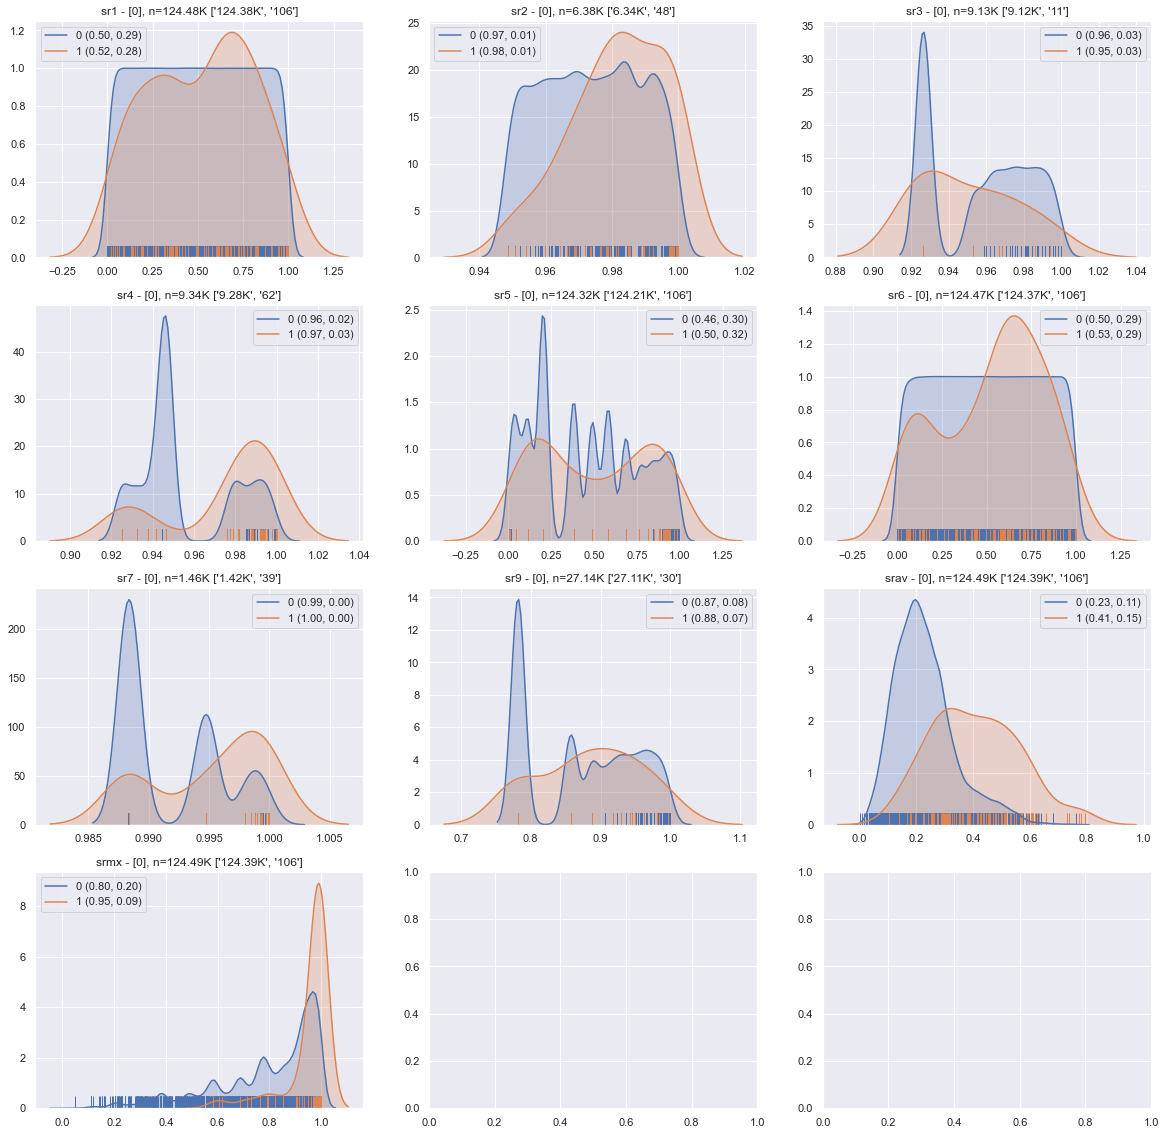

In [24]:
# Create distribution plot per new metric and target
# Can remove zero if requiered (zero percentiles are for zero values)
Viz.change_default(3)
#Viz.kernel_plot(Xrnk, y, rnk_cols, remove_val=[None], rug_sample=2500)
Viz.kernel_plot(Xrnk, y, rnk_cols, remove_val=[0], rug_sample=2500)

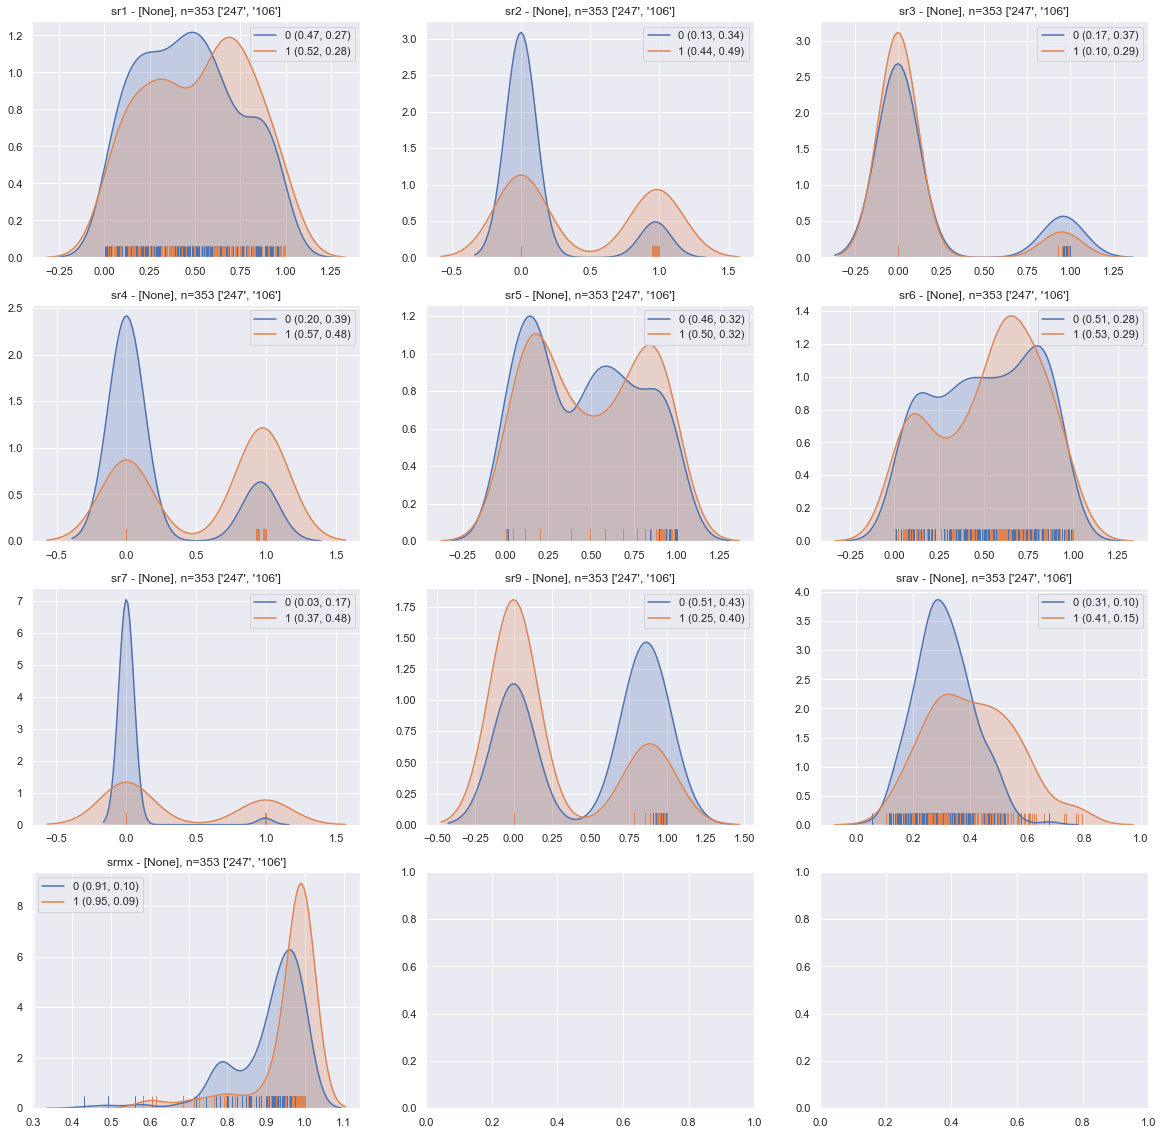

In [25]:
# Create distribution plot per new metric and target on undersample data
Viz.kernel_plot(Xrnk_rs, yrs, rnk_cols, remove_val=[None], rug_sample=2500)

### Rank Metrics Distributions - Conclusions

#### Standardized Rank Metrics
 - It is expected that metric ranks will follow a similar behavior than raw metric.
 - SR1, SR5, SR6 seems to not add much additional information.
 - SR2, SR3, SR4, SR7 show a wider spectrum can be useful to identify failure (although is similar behavior compared to original metrics)


#### Average / Max Standardized Rank
 - One common conclusion among metrics is that failure can be identified in extreme values.
 - It seems that average / max percentile makes a good job accumulating such extreme values.
 
### Rank Metrics Correlation

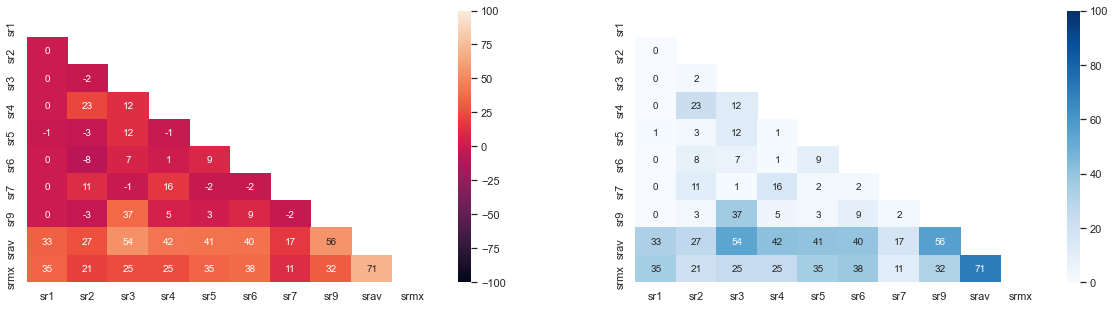

In [26]:
# Check correlation between rank metrics
Viz.change_default()
corr_matrix = Tools.get_corr(Xrnk, rnk_cols)
Viz.corr_plot(corr_matrix)

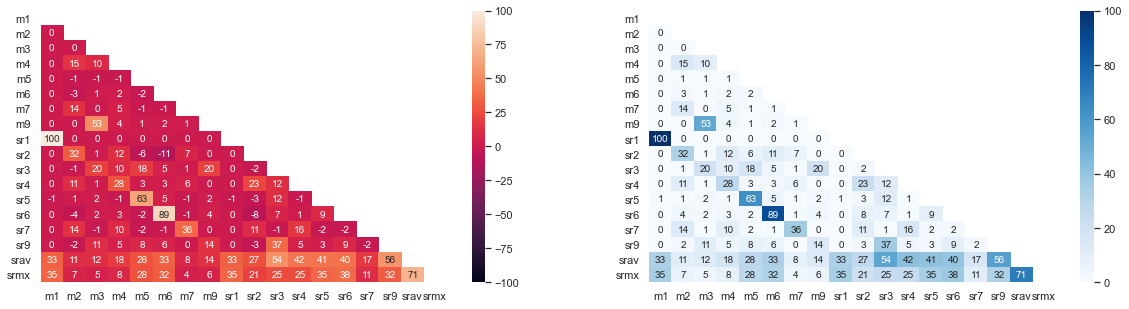

In [27]:
# Check correlation between rank metrics and base metrics
corr_matrix = Tools.get_corr(pd.concat([Xrnk, X[num_cols]], axis=1), num_cols + rnk_cols)
Viz.corr_plot(corr_matrix)

### Rank Metrics Correlation

- Note that SR1/M1, SR5/M5, SR6/M6 are highly correlated. Perhaps SR1, SR5, SR6 are redundant.
- Same applies to SRAV and SRMX.
- For linear based models. Perhaps PCA can help reduce collinearity as well as reduce unnecessary features.